In [1]:
# import libraries
# importing data and libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# Define the file path (Update this based on your file location)
file_path1 = r"C:\Users\aniru\Desktop\SMU-Y4\Y4S2\Fin Innovation\Data\ETH.csv"  
# Check if eth file exists
if os.path.exists(file_path1):
    # Read the dataset
    eth = pd.read_csv(file_path1)
    print("Dataset loaded successfully!")
    print(eth.head())  # Display first few rows
else:
    print("Error: File not found! Check the file path.")
eth['date'] = pd.to_datetime(eth['date'], format='%d-%m-%y')

Dataset loaded successfully!
       date  eth_close_price (ETH-USD)  eth_rewards_yield_index_(STYETH)  \
0  02-10-22                  1276.0935                            5.2688   
1  03-10-22                  1323.4392                            5.3649   
2  04-10-22                  1362.1266                            5.4568   
3  05-10-22                  1352.8372                            5.4359   
4  06-10-22                  1351.7095                            5.5289   

   fear_greed_multiplier fear_greed_classification  
0                     24              Extreme Fear  
1                     24              Extreme Fear  
2                     20              Extreme Fear  
3                     25              Extreme Fear  
4                     26                      Fear  


In [19]:
# Ensure 'date' is the index
if 'date' in eth.columns:
    eth['date'] = pd.to_datetime(eth['date'])
    eth = eth.set_index('date').sort_index()

# Define forecast horizons (1 to 14 days ahead)
forecast_days = list(range(1, 15))

# Define independent variables (X)
X = eth[['fear_greed_multiplier', 'eth_close_price (ETH-USD)', 'eth_rewards_yield_index_(STYETH)']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dictionary to store models and forecast performance
models = {}
results = []
forecast_results = []

# Train separate models for each forecast horizon
for horizon in forecast_days:
    y = eth['eth_rewards_yield_index_(STYETH)'].shift(-horizon)  # Shift forward

    # Align X and y (remove NaN rows)
    valid_rows = y.notna()
    X_horizon = X[valid_rows]
    y_horizon = y[valid_rows]

    # Standardize X_horizon
    X_horizon_scaled = scaler.transform(X_horizon)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_horizon_scaled, y_horizon, test_size=0.2, random_state=42)

    # Hyperparameter tuning for Elastic Net
    param_grid = {
        'alpha': np.logspace(-4, 1, 50),  # Regularization strength
        'l1_ratio': np.linspace(0, 1, 10)  # Balance between Lasso (1) and Ridge (0)
    }
    grid_search = GridSearchCV(ElasticNet(max_iter=1000), param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X_train, y_train)

    # Best parameters
    best_alpha = grid_search.best_params_['alpha']
    best_l1_ratio = grid_search.best_params_['l1_ratio']

    # Train final Elastic Net model
    model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Store model and results
    models[horizon] = model
    results.append({'Forecast Horizon': horizon, 'RMSE': rmse, 'MAE': mae})

    # Predict future values using the last available data
    latest_X = X.iloc[-1:].values  # Get last available independent variable data
    latest_X_scaled = scaler.transform(latest_X)
    future_prediction = model.predict(latest_X_scaled)[0]

    forecast_results.append({'Forecast Horizon': horizon, 'Predicted_ETH_Yield_Index': future_prediction, 'RMSE': rmse, 'MAE': mae})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
forecast_df = pd.DataFrame(forecast_results)


c:\Users\aniru\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.070e+01, tolerance: 4.394e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\aniru\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.040e+01, tolerance: 4.342e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

In [30]:
# Get predictions for both training and testing datasets
# - For 'train': Predict using X_train and flatten the output to a 1D array.
# - For 'test': Predict using X_test and flatten the output to a 1D array.
predictions = {
    'train': model.predict(X_train).flatten(),
    'test': model.predict(X_test).flatten()
}

# Initialize an empty dictionary to store evaluation metrics for both datasets.
metrics = {}

# Iterate over the two datasets: 'train' and 'test'
for dataset in ['train', 'test']:
    # Select the true target values based on the dataset.
    # If dataset is 'train', use y_train; otherwise, use y_test.
    y_true = y_train if dataset == 'train' else y_test
    
    # Calculate evaluation metrics for the current dataset:
    # - Mean Squared Error (mse)
    # - Mean Absolute Error (mae)
    # - R-squared score (r2)
    metrics[dataset] = {
        'mse': mean_squared_error(y_true, predictions[dataset]),
        'mae': mean_absolute_error(y_true, predictions[dataset]),
        'r2': r2_score(y_true, predictions[dataset])
    }
    
    # Calculate Root Mean Squared Error (rmse) from the mse and add it to the metrics dictionary.
    metrics[dataset]['rmse'] = np.sqrt(metrics[dataset]['mse'])

# Print the R² value for the test dataset with six decimal places.
print(f"R²: {metrics['test']['r2']:.6f}")

# -------------------------
# Daily evaluation for the 14 days
# -------------------------

# Define the number of days to evaluate.
days_to_evaluate = 14

# Calculate daily errors for the 'days_to_evaluate'.
# For each day, compute:
# - RMSE: Square root of the squared difference between actual and predicted values.
# - MAE: Absolute difference between actual and predicted values.
daily_errors = {
    'rmse': np.sqrt((y_train[:days_to_evaluate] - predictions['train'][:days_to_evaluate]) ** 2),
    'mae': np.abs(y_train[:days_to_evaluate] - predictions['train'][:days_to_evaluate])
}

# Print header for the per-day error metrics table.
print("\nDay-wise Metrics for ETH")
print("Day\tActual\t\tPredicted\tRMSE")
print("------------------------------------------------------------")

# Loop over each day in the evaluation period and print the actual, predicted, RMSE, and MAE values.
for day in range(days_to_evaluate):
    # Get actual value from y_train for the current day.
    actual = y_train[day]
    # Get predicted value from the training predictions for the current day.
    predicted = predictions['train'][day]
    # Print the day number (starting at 1), actual value, predicted value, RMSE, and MAE.
    print(f"{day + 1}\t{actual:.6f}\t{predicted:.6f}\t{daily_errors['rmse'][day]:.6f}")

R²: 0.820568

Day-wise Metrics for ETH
Day	Actual		Predicted	RMSE
------------------------------------------------------------
1	3.380700	3.196394	0.184306
2	3.600400	3.739386	0.138986
3	3.512400	3.893572	0.381172
4	3.555100	3.912109	0.357009
5	5.001900	4.768315	0.233585
6	3.083700	3.128709	0.045009
7	3.585700	3.832832	0.247132
8	3.204700	3.297252	0.092552
9	3.251200	3.361355	0.110155
10	3.148800	3.559059	0.410259
11	3.188400	3.199994	0.011594
12	4.454000	4.354371	0.099629
13	3.353300	3.322126	0.031174
14	3.231700	3.303340	0.071640


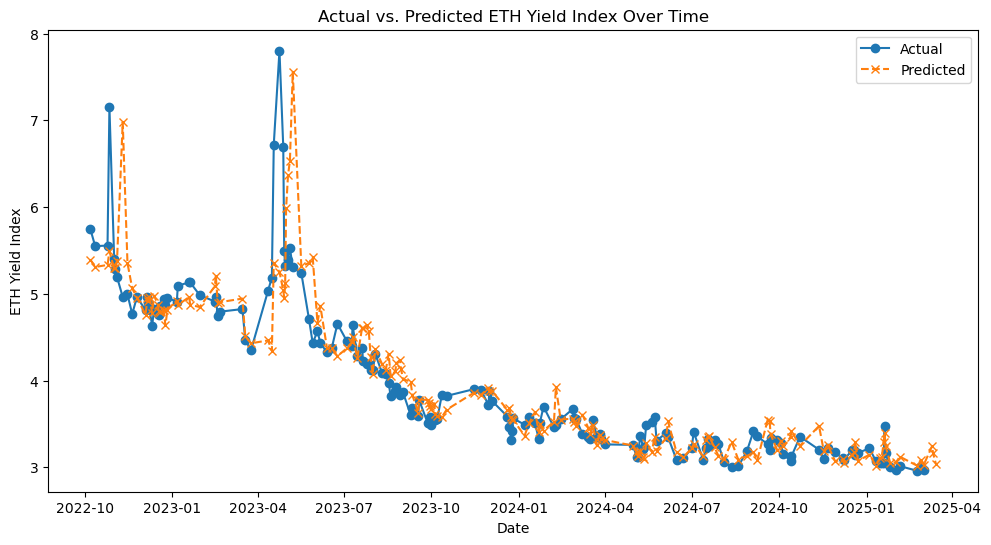

In [15]:
# Train-test split with indices
X_train, X_test, y_train, y_test_split, train_indices, test_indices = train_test_split(
    X_scaled, y, range(len(y)), test_size=0.2, random_state=42
)

# Ensure y_pred is calculated using the test set
y_pred = models[1].predict(X_test)  # Adjust for desired forecast horizon

# Create a DataFrame for plotting
comparison_df = pd.DataFrame(index=eth.iloc[test_indices].index)
comparison_df["Actual"] = y_test_split
comparison_df["Predicted"] = y_pred

# Sort by index (date) for proper visualization
comparison_df = comparison_df.sort_index()

# Plot actual vs. predicted over time
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df["Actual"], label="Actual", linestyle="-", marker="o")
plt.plot(comparison_df.index, comparison_df["Predicted"], label="Predicted", linestyle="--", marker="x")

# Labels and title
plt.xlabel("Date")
plt.ylabel("ETH Yield Index")
plt.title("Actual vs. Predicted ETH Yield Index Over Time")
plt.legend()
plt.show()

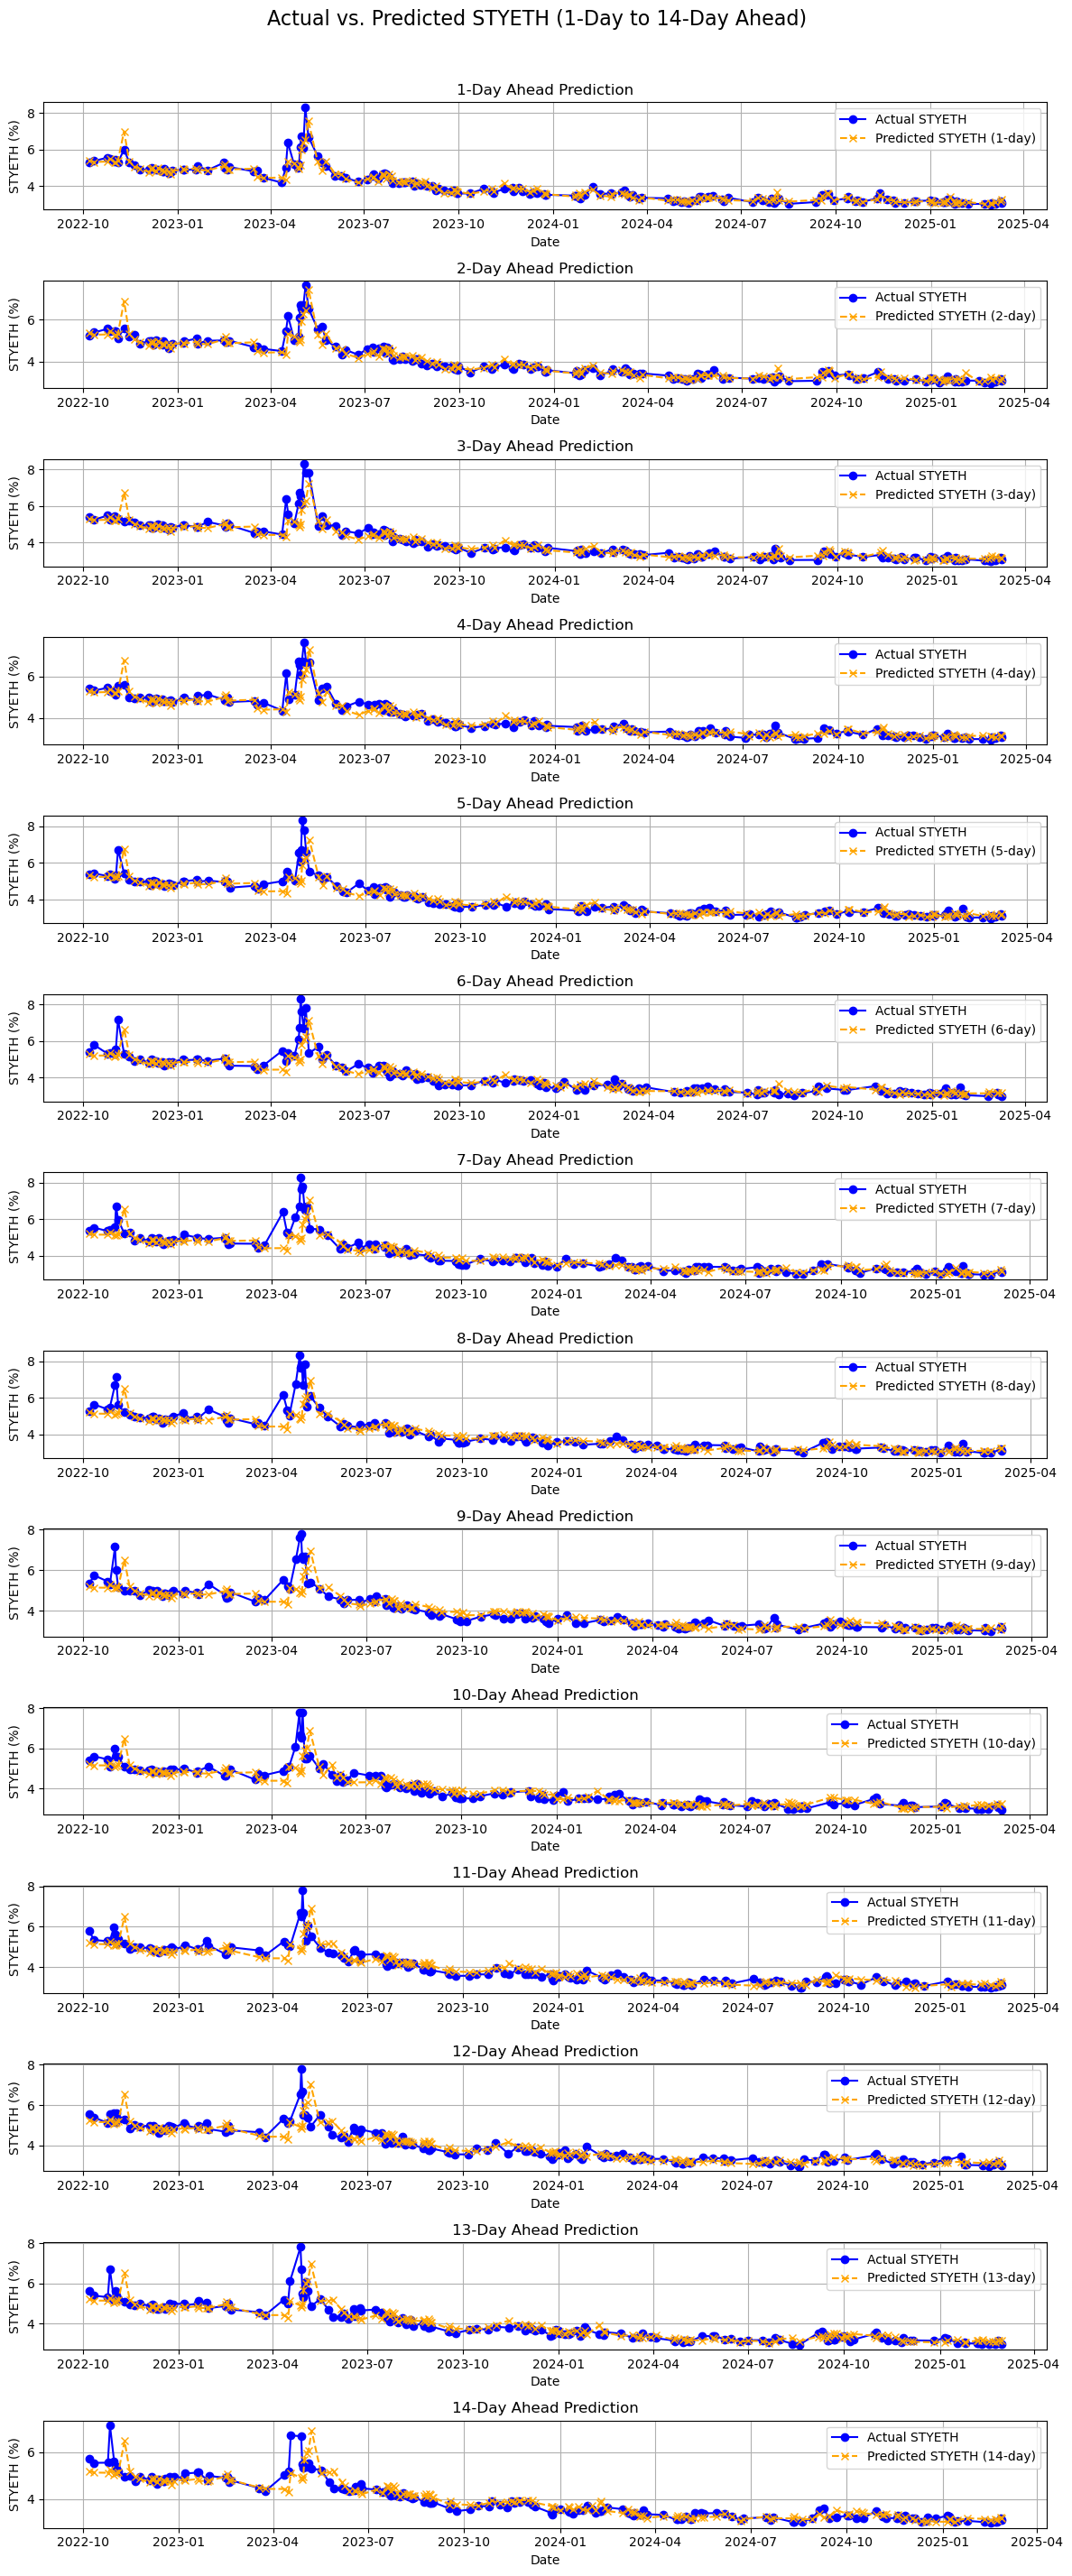

In [12]:
# Create a figure with 14 subplots (one for each forecast horizon)
fig, axes = plt.subplots(14, 1, figsize=(12, 30))
fig.suptitle('Actual vs. Predicted STYETH (1-Day to 14-Day Ahead)', fontsize=16)

for n, horizon in enumerate(forecast_days):
    # Align target variable with forecast horizon
    y = eth['eth_rewards_yield_index_(STYETH)'].shift(-horizon)

    # Remove NaN values
    valid_rows = y.notna()
    X_horizon = X[valid_rows]
    y_horizon = y[valid_rows]

    # Standardize features
    X_horizon_scaled = scaler.transform(X_horizon)

    # Train-test split with date indices
    X_train, X_test, y_train, y_test_split, train_indices, test_indices = train_test_split(
        X_horizon_scaled, y_horizon, eth.index[valid_rows], test_size=0.2, random_state=42
    )

    # Convert y_test_split and y_pred to Series with proper index
    y_test_series = pd.Series(y_test_split, index=test_indices)
    y_pred_series = pd.Series(models[horizon].predict(X_test), index=test_indices)

    # Sort values by date for proper visualization
    y_test_series = y_test_series.sort_index()
    y_pred_series = y_pred_series.sort_index()

    # Plot actual vs. predicted for this forecast horizon
    axes[n].plot(y_test_series.index, y_test_series, label='Actual STYETH', color='blue', marker='o', linestyle='-')
    axes[n].plot(y_pred_series.index, y_pred_series, label=f'Predicted STYETH ({horizon}-day)', color='orange', linestyle='--', marker='x')

    # Formatting
    axes[n].set_title(f'{horizon}-Day Ahead Prediction', fontsize=12)
    axes[n].set_xlabel('Date')
    axes[n].set_ylabel('STYETH (%)')
    axes[n].legend()
    axes[n].grid()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Leaves space for the suptitle
plt.show()
